<h1><center>Traveling Santa 2018 - Prime Path</center></h1>
<h2><center>Sid Ravinutala</center></h2>
<center>August 2019</center>

In [4]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import dask_distance as ddist

from dask.distributed import Client
from dask import delayed
from scipy.spatial import distance

from tqdm import tqdm_notebook as tqdm

from multiprocessing import Pool

from simulated_annealing import *

In [27]:
cities_arr = pd.read_csv("cities.csv", index_col=0).values

# The Problem Statement

## Traveling salesman problem (TSP) with a twist##

If every 10th trip doesn't originate from a prime, it costs an extra 10%<br>

Other details:
1. ~200k points!
2. Euclidean distance
3. Variable density
4. Must begin and end with city id 0

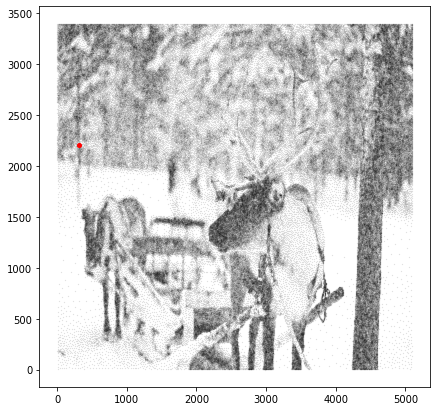

In [23]:
f, ax = plt.subplots(figsize=(7, 7))
ax.plot(cities_arr[:, 0], cities_arr[:, 1], ".k", alpha=0.2, ms=0.5)
ax.plot(cities_arr[0, 0], cities_arr[0, 1], ".r", ms=8)

## Can't be solved using brute Force

* NP-Hard problem: Solution cannot be found in polynomial time
* Not in NP: A solution cannot be verified as being optimal in polynomial time

Complexity is O(N!). Need an algorithm for heuristic approximation.

* Integer programming: Branch-and-Bound
* Stochastics Algorithms: Evolutionary Algorithms / <b>Simulated Annealing</b>

# Tools and solutions

## Considered *three ways* to approach the problem:
1. <h4>Global optimization:</h4>
   + Better solution<br>
   - Extremely large search space<br>
   - Will be extremely slow unless there is a fast implementation<br>
   <br>
2. <h4>Greedy search:</h4>
   + Easy to implement<br>
   - Hard to refine<br>
   - Might give terrible results<br>
   <br>
3. <h4>Tiered optimization:</h4>
   - Sacrificing optimality<br>
   + Easy(ish) to implement<br>
   + Allows for parallelization<br>

## Packages and options considered

1. [Lin-Kernighan heuristic (LKH)](http://akira.ruc.dk/~keld/research/LKH/):<br>
  \+ Written in C: Fast!<br>
  \+ Variable $\lambda$-opt<br>
  \- Written in C: ugh... pointers<br>
  \- Single core only<br>
<br>
2. [DEAP](https://deap.readthedocs.io/en/master/):<br>
  \+ Python implementation<br>
  \+ Framework for multiple EAs<br>
  \+ Some parallelization possible<br>
  \- Require distance matrix to be specified (to be fast)<br>
  \- Python implementation: slow<br>
<br>

## Packages and options considered (2)

3. [Google OR tools](https://developers.google.com/optimization/routing/tsp)<br>
  \+ Python api<br>
  \+ Reasonably fast<br>
  ? Have to work with integers (variable density!)<br>
  \- Not scalable<br>
  \- No multicore support<br>
<br>
4. Simulated Annealing with 2-opt<br>
  \- Custom code: Lots of code to write<br>
  \- Limited in complexity: just uses 2-opt<br>
  \- Python: slow<br>
  \+ Custom code: Flexible <br>
  \+ Demonstrate coding ability :)<br>

## Technical Detour: 2-opt

<center><img align="middle" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/2-opt_wiki.svg/1280px-2-opt_wiki.svg.png" alt="alt text" width="300"></center>
<p style="text-align:right;font-size:10px" >Courtesy: Wikipedia</p>

# Approaches

## Approach 1: The devil you know...

1. Use Evolutionary algorithms in DEAP
2. But this means we need to calculate the distance matrix: ~ 200k x 200k in dimension

## Approach 1: 1. Calculating distances
- Can use `scipy.distance.pdist` but doesn't scale<br>
- Parallel process using dask/multiprocessing/joblib

In [ ]:
def calculate_distance(a):
    idx1 = a
    idx2 = np.arange(a, n_cities)
    out = ((cities_arr[idx1] - cities_arr[idx2])**2).sum(axis=1)
    return np.pad(out, (a, 0), mode='constant', constant_values=(0,0))

In [ ]:
pool = Pool(processes=4) 
out = pool.map(calculate_distance, range(1000))

Too slow even on my 2018 15" MacBook pro. Need more compute!

## Approach 1: 2. Getting more compute
1. Setup an AWS EC2 instance with 96 cores
2. Run!

<center><img align="middle" src="images/distance_96core.png" alt="alt text" width="1200"></center>


<center><img width="400" alt="Clock" src="https://upload.wikimedia.org/wikipedia/commons/3/37/Clock.gif"></center>

## Approach 1: RIP

* Ran it for a few hours then saved distances from each city
* For the 1st 10000 cities (1/20th of the data... kind of), size of array in memory is 14Gb!
   * Saving as unsigned int doesn't save much
* Need to write cleverer code / Have more memory 

#### Creating a distance matrix may be possible but fast memory access is not trivial 

## Approach 2: What's the best TSP tool out there?
1. Use Lin-Kernehan Heuristic
2. This means can't easily code up the *prime* constraint
3. The penalty might be worth it

<center><img width="400" alt="Clock" src="https://upload.wikimedia.org/wikipedia/commons/3/37/Clock.gif"></center>

In [29]:
route = pd.read_csv("tsp_solution.csv", skiprows=5, skipfooter=2).values.squeeze()
route = route -1

/Users/Sid_Ravinutala/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [31]:
cities_ordered = cities_arr[route]

## Approach 2: Five hours later... 

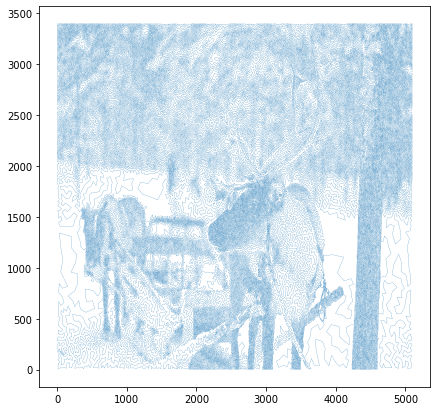

In [35]:
f, ax = plt.subplots(figsize=(7, 7))
plt.plot(cities_ordered[:,0], cities_ordered[:,1], lw=0.2);

Not bad! Score of **1516777**. 
Solution is **0.2%** worse than the best.

In [13]:
(1516777 - 1513747)*100/1513747

0.2001655494610394

## Approach 2: What about the constraint?

* Part of the challenge (fun!) is in working in the constraint
* Modifying the distance metric is not trivial though entirely possible

<center><img align="middle" src="images/lkh_distance.png" alt="alt text" width="1200"></center>


## Approach 2: To be continued...

* Modifying C code is definitely possible but may be a rabbit hole we get lost in
* LKH 3.0 includes some constraints so may be easier to patch


## Approach 3: Simulated Annealing with 2-opt
* Write python code for simulated annealing
* Use 2-opt
* Use tiered optimization

### Tiered optimization
See [Alhanjouri, Mohammed. (2018)](https://www.researchgate.net/publication/326325068_Proposed_Algorithms_to_solve_Big_Data_traveling_salesman_problem) - First result to searching "TSP Big Data"
1. Cluster data into N clusters
2. Solve the smaller TSP for the N cluster centers
3. For two adjacent clusters in the trip, find closest point - this is where the cluster will connect
4. Solve the smaller TSP within each cluster (parallelizable!)
    * Ensure start and end are fixed
5. Append trips within cluster in the order specified by #2


# Approach 3: Simulated Annealing
[My blog post](https://sidravi1.github.io/blog/2018/03/01/the-connection-between-simulated-annealing-and-mcmc-part-1) on Simulated Annealing

In [ ]:
for e in range(Epoch):
    thresholds = np.random.uniform(0, 1, size=L_int)
    for l in range(L_int):
        # Propose using 2-opt
        X_new = propose(X_old, fix_start, fix_end)
        # Calculate cost
        E_new = trip_distance_penalized(
            X_new, distances, city_labels, all_primes, offset=offset   
        )
        alpha = min(1, np.exp((E_old - E_new) / T))
        threshold = thresholds[l]
        if (E_new < E_old) or (alpha > threshold):
            if E_new < E_old:
                X_best = X_new
                E_best = E_new

            E_old = E_new
            X_old = X_new

    T = T * T_decay
    L = L * 1.01
    L_int = int(np.round(L, 0))


#### That easy!

## Approach 3: Simulated Annealing *with warm restarts*

In [ ]:
for r in range(restarts):
    X_old, E_old = run_epoch(
        epochs,
        T,
        T_decay,
        L,
        X_old,
        E_old,
        distances,             # Distance matrix
        city_labels,           # For the prime constraint
        all_primes,            # For the prime constraint
        fix_start,             # if you want to keep start city fixed
        fix_end,               # if you want to keep last city fixed
        offset,
    )
    T_decay = T_decay * 1.03   # Decay temperature faster each time

return X_old

## Approach 3: Clustering

* Used MiniBatchKMeans with a batch size of 10000 for scalability
* Paper suggests other methods but parked for now
* Choose 300 clusters

#### Choice of number of cluster

* Higher number of clusters simplifies the sub-cluster TSP problem
* Lower number of clusters is less likely to converge to local optima
* Tune!


In [65]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from cycler import cycler
import seaborn as sns

n_clusters = 300
clusterer = MiniBatchKMeans(n_clusters = n_clusters, batch_size=10000)
clusterer.fit(cities_arr)

ids = clusterer.predict(cities_arr)
cluster_centers = clusterer.cluster_centers_

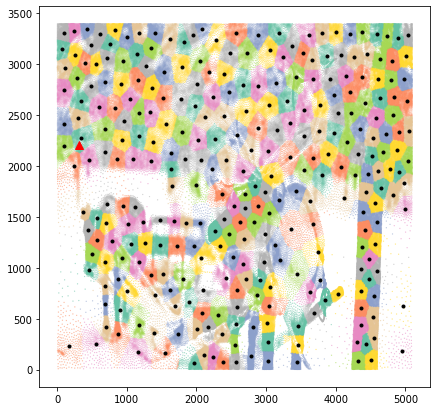

In [66]:
f, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(x=cities_arr[:,0], y=cities_arr[:,1], hue=ids[:], s=0.3, 
                edgecolor=None, palette='Set2', legend=None, alpha=0.5)
plt.plot(cluster_centers[:, 0], cluster_centers[:, 1], ".k")
plt.plot(cities_arr[0, 0], cities_arr[0, 1], "^r", ms=8)

## Approach 3: Connecting the cluster centers

In [ ]:
order_idx, cluster_order = run_simulated_annealing(cluster_centers, restarts=5, fix_start=None, fix_end=None)

Make sure the cluster with city 0 is first! 

Only important for prime constraint

In [ ]:
roll_count = np.argwhere(order_idx == starting_cluster)[0][0]
order_idx = np.roll(order_idx, roll_count)
cluster_order = np.roll(cluster_order, roll_count, axis=0)

<center><img align="middle" src="images/connect_clusters.png" alt="alt text" width="700"></center>

## Approach 3: Find start and end points for each cluster

In [ ]:
smooth_route = []
smooth_route_ids = []
for i in range(n_clusters - 1):
    # What is the closest point between this and the next cluster?
    a = cities_arr[clusterer.labels_ == order_idx[i]]
    b = cities_arr[clusterer.labels_ == order_idx[i+1]]
    
    A = distance.cdist(a, b)
    
    a_min, b_min = np.unravel_index(A.argmin(), A.shape) 
    smooth_route += [a[a_min], b[b_min]]
    smooth_route_ids += [a_min, b_min]
    
a = cities_arr[clusterer.labels_ == order_idx[-1]]
b = cities_arr[clusterer.labels_ == order_idx[0]]
A = distance.cdist(a, b)
a_min, b_min = np.unravel_index(A.argmin(), A.shape) 
smooth_route = [b[b_min]] + smooth_route + [a[a_min]]
smooth_route_ids = [b_min] + smooth_route_ids + [a_min]

smooth_points = np.vstack(smooth_route)
smooth_points_id = np.vstack(smooth_route_ids).squeeze()

<center><img align="middle" src="images/smooth_connect_clusters.png" alt="alt text" width="700"></center>

## Approach 3: Solve TSP within each cluster
* Again, do it on an EC2 c5n.9xlarge with 36 cores
* Write out each cluster's "optimal" trip
* Combine them in the right order

<center><img align="middle" src="images/sub_tsp_36core.png" alt="alt text" width="1200"></center>

<center><img width="400" alt="Clock" src="https://upload.wikimedia.org/wikipedia/commons/3/37/Clock.gif"></center>

## Approach 3: 2-5 hrs later...

<center><img align="middle" src="./images/sim_anneal_result.png" alt="alt text" width="500"></center>

## Approach 3: Conclusion

* Despite adding the constraint, it can't beat LKH
* Some sub-cluster solutions may be improved (see dense areas)
* Tuning might help especially in dense clusters
* Other clustering methods? K-mean with covariance - [See blogpost](https://sidravi1.github.io/blog/2019/03/27/back-to-basic-with-david-mackay-ii) 

# Next steps and improvements

### Six options:
1. Tune Simulated Annealing with restarts
2. Patch LKH C code to add prime constraint
3. Run Simulated Annealing for longer
4. Local search from LKH
5. Use Google OR Tools instead of SA
6. Use Genetic Algorithms

In [14]:
data = {'Tune SA':[2, 3, 10, 12, ("A number of parameters can be tuned from temperature, number of epochs, restarts, number of batches. "
                          "Even number of clusters can be tuned. Experimentation might be computationally expensive")], 
        'Patch LKH': [7, 7, 3, 32, ("We could look at version 3.0 and the prime constraint to it. Unclear how much work this would be.")],
        'Local search from LKH': [2, 6, 5, 8, ("We know that LKH solution is close to optimal. Minor local changes around primes may allow"
                                               " us to improve this solution. SA or other stochastic search algorithms may be used.")],
        'Run SA for longer': [1, 2, 6, 4, ("The results presented are for 5 restarts with 500 epochs each. We could extend this at the cost"
                                     " of additional computer time.")],
        'Google OR Tools': [4, 5, 4, 16, ("We can modify our code to use Google OR tools for integer programming. Might perform better"
                                   " and possibly faster")],
        'DEAP with tiered': [3, 4, 5, 5, ("Instead of using SA, we could use another optimization method for the smaller TSP problems."
                                           " This may involve writing some harness code to parallelize DEAP. May lead to better solutions.")],
        'Genetic Algorithms': [5, 5, 8, 60, ("A number of other biological optimization can be adapted for this. Some are Particle swarm, "
                                         "Ant-colony optimation. See http://www.cleveralgorithms.com/nature-inspired/index.html")]}
        
        
data_df = pd.DataFrame.from_dict(data, orient='index').reset_index()
data_df.columns = ['Name', 'Difficulty', 'Reward', 'Compute', 'Risk', 'Comments']

In [15]:
import altair as alt 
brush = alt.selection(type='single', resolve='global')


base = alt.Chart(data_df).mark_circle(size=500).encode(
            size=alt.Size('Risk', scale=alt.Scale(range=[1, 5000]), legend=None),
            tooltip=['Name', 'Comments'],
            color=alt.condition(brush, 'Name', alt.ColorValue('gray'))
        ).add_selection(
                brush
        )


left = base.encode(
    x=alt.X('Difficulty', scale=alt.Scale(domain=[0, 10])),
    y=alt.Y('Reward', scale=alt.Scale(domain=[0, 10])),
)

right = base.encode(
    x=alt.X('Difficulty', scale=alt.Scale(domain=[0, 10])),
    y=alt.Y('Compute', scale=alt.Scale(domain=[0, 12])),
)

plot = left | right

In [16]:
plot.save('../reveal.js/charts/next_options.html')

## Weighing up each of the options

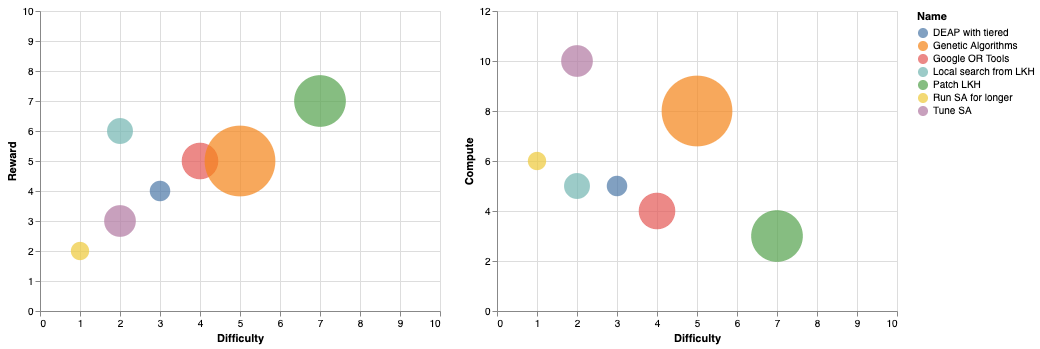

In [17]:
plot

<h1><center>Thank you!</center></h1>
<h2><center>Questions?</center></h2>